<a href="https://colab.research.google.com/github/alepenaa94/TP1_Real_or_Not/blob/master/TP1_Real_or_Not.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRABAJO PRÁCTICO 1: Análisis Exploratorio de Datos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 10)
sns.set(style="darkgrid")
%matplotlib inline

my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
train_df = pd.read_csv('./Data/train.csv', encoding='latin-1',dtype={'id': np.uint16,'target': np.bool})

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,True
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,True
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,True
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",True
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True


## Tratamiento de datos

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null uint16
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null bool
dtypes: bool(1), object(3), uint16(1)
memory usage: 200.9+ KB


Podemos observar que las columnas <b><i>"keyword"</i></b> y <b><i>"location"</i></b> poseen algunos valores nulos, vamos a ver si podemos realizar algun tratamiento en particular.

In [5]:
train_df['keyword'].describe()

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

In [0]:
train_df['keyword'].fillna(value='',inplace=True)

In [6]:
train_df['keyword'] = train_df['keyword'].str.replace('%20',' ')

Posiblemente luego analicemos los textos y veamos la posibilidad de completar estos keyword vacios con algun valor mas significativo

In [7]:
train_df['location'].describe()

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

In [8]:
train_df['location'].sample(30)

6827                               NaN
5120                 USA, North Dakota
1376               Melbourne Australia
4805                               NaN
5213                         London UK
4130                       Dicky Beach
6629    Iraq|Afghanistan| RSA |Baghdad
2564                       New England
936                      Guildford, UK
664                     Tripsburg, ms.
5670            U.S.A.   FEMA Region 5
1128    Warwick, RI @Dollarocracy also
3798                   Tallahassee, FL
2183                               NaN
4908                               NaN
5510                       Livonia, MI
1704                  Peterborough, On
2590                               USA
4754                               NaN
119                        Switzerland
5208                Winnipeg, Manitoba
4548          someplace living my life
1856                 San Diego, Texas.
5925                               NaN
4381                         worldwide
5448                     

Por ahora dejamos en blanco estos datos, se observa que la ubicacion ingresada no es siempre algo coherente.

## Primeros analisis

In [9]:
train_df['word_count'] = train_df['text'].str.count(' ') + 1
train_df['not_target'] = 0
train_df.loc[train_df['target']==0,'not_target'] = 1

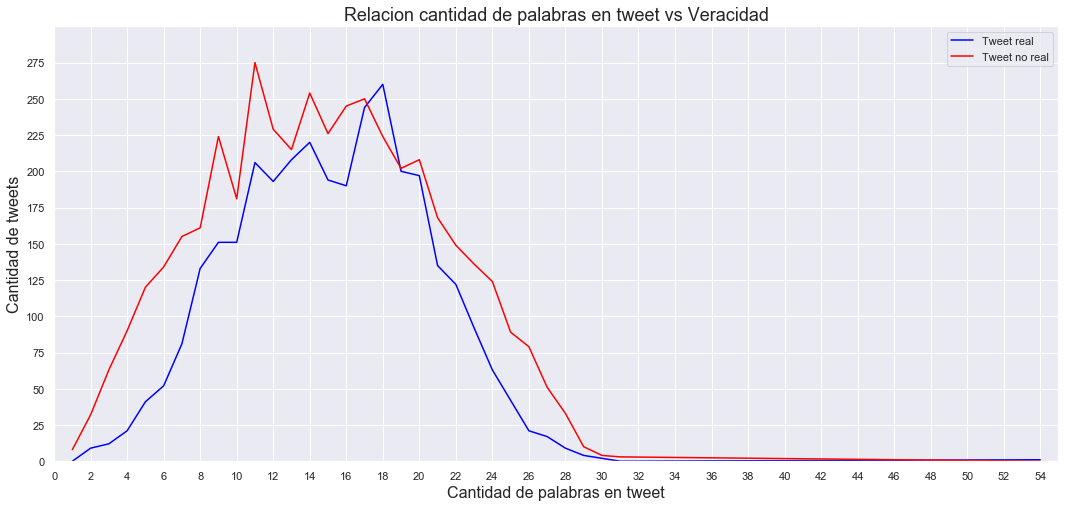

In [10]:
df = train_df.groupby('word_count').agg({'target':'sum','not_target':'sum'}).reset_index()

plt.figure(figsize=(18,8))
ax = sns.lineplot(x='word_count',y='target',data=df,color="blue", label='Tweet real')
ax = sns.lineplot(x='word_count',y='not_target',data=df,color="red", label='Tweet no real')
ax.set_ylim(0,300)
ax.set_yticks(range(0,300,25))
ax.set_xlim(0,55)
ax.set_xticks(range(0,55,2))

ax.set_title('Relacion cantidad de palabras en tweet vs Veracidad', fontsize=18)
ax.set_xlabel('Cantidad de palabras en tweet',fontsize=16)
ax.set_ylabel('Cantidad de tweets', fontsize=16);

## Análisis de la longitud de los tweets

In [11]:
#Creamos una columna con la longitud del tweet.
train_df['longitud_del_tweet'] = train_df['text'].str.len()

In [12]:
#Analizamos las estadísticas de los tweets verdaderos.
train_df[train_df['target']]['longitud_del_tweet'].describe()

count    3271.000000
mean      108.444207
std        29.511567
min        14.000000
25%        88.000000
50%       115.000000
75%       136.000000
max       161.000000
Name: longitud_del_tweet, dtype: float64

In [13]:
#Analizamos las estadísticas de los tweets falsos.
train_df[~train_df['target']]['longitud_del_tweet'].describe()

count    4342.000000
mean       95.981345
std        36.100118
min         7.000000
25%        68.000000
50%       101.000000
75%       130.000000
max       163.000000
Name: longitud_del_tweet, dtype: float64

In [14]:
train_df = train_df.astype({'longitud_del_tweet':np.uint8})

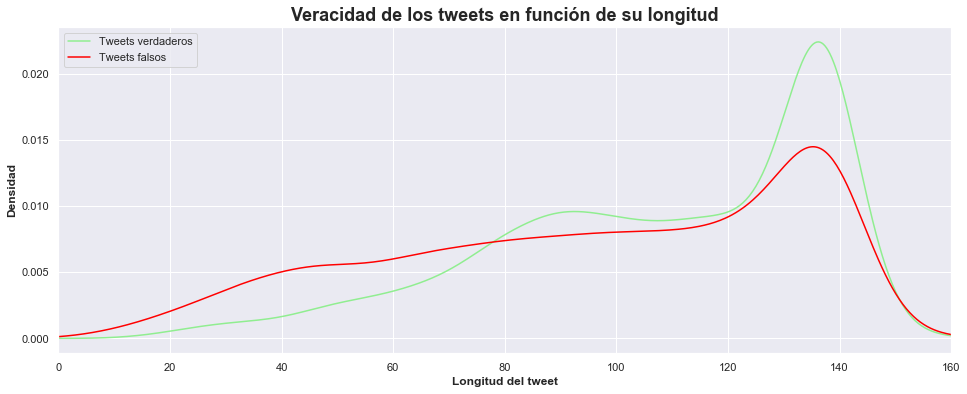

In [15]:
fig= plt.figure()
ax = fig.add_subplot(111)

plt.title('Veracidad de los tweets en función de su longitud',fontsize=18,fontweight='bold')

train_df[train_df['target']]['longitud_del_tweet'].plot.kde(color='lightgreen', figsize=(16, 6), label = 'Tweets verdaderos')
train_df[~train_df['target']]['longitud_del_tweet'].plot.kde(color='red', ax=ax, figsize=(16, 6), label = 'Tweets falsos')

ax.set_xlabel('Longitud del tweet', fontsize=12, fontweight='bold')
ax.set_ylabel('Densidad', fontsize=12, fontweight='bold')

ax.set_xlim(0, 160) #Seteamos los límites del eje x conociendo el valor máximo y mínimo de la longitud de los tweets.
ax.legend()

plt.show()

En está visualización podemos observar que los tweets que tienen una longitud menor a 80 caracteres son en su mayoría falsos, mientras que los que tienen una longitud superior tienden a ser verdaderos. Tambíen podemos ver que la longitud de los tweets tiene un pico llegando a los 140 caracteres, lo cuál tiene sentido considerando las limitaciones que la plataforma solía tener respecto a la longitud de los mismos.

## Análisis de los keywords

Como vimos previamente, la columna keywords tiene **61 registros** con valores nulos. Como es una cantidad pequeña en relación a la cantidad total de registros (**7613 registros**), para este análisis vamos a descartar los registros nulos.

In [16]:
keywords_verdaderos = train_df.loc[~train_df['keyword'].isnull() & train_df['target']]['keyword']
keywords_verdaderos.value_counts()

wreckage       39
derailment     39
outbreak       39
typhoon        37
oil spill      37
               ..
epicentre       1
electrocute     1
blazing         1
body bags       1
ruin            1
Name: keyword, Length: 220, dtype: int64

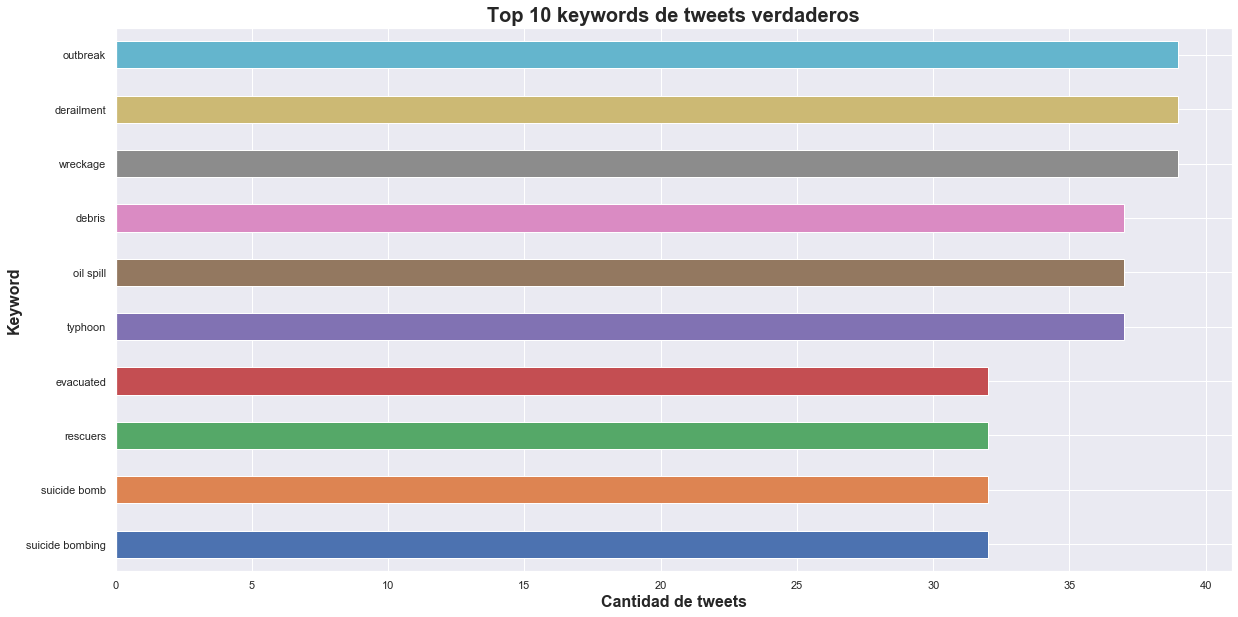

In [17]:
keywords_verdaderos.value_counts().sort_values(ascending=False).head(10).T\
    .sort_values(ascending=True)\
    .plot(figsize=(20,10),kind='barh',rot=0,color=my_colors);

plt.ylabel('Keyword', fontsize=16, fontweight='bold')
plt.title('Top 10 keywords de tweets verdaderos',fontsize=20, fontweight='bold')
plt.xlabel('Cantidad de tweets', fontsize=16, fontweight='bold');

In [18]:
keywords_falsos = train_df.loc[~train_df['keyword'].isnull() & ~train_df['target']]['keyword']
keywords_falsos.value_counts()

body bags          40
armageddon         37
harm               37
ruin               36
deluge             36
                   ..
outbreak            1
typhoon             1
suicide bombing     1
suicide bomber      1
oil spill           1
Name: keyword, Length: 218, dtype: int64

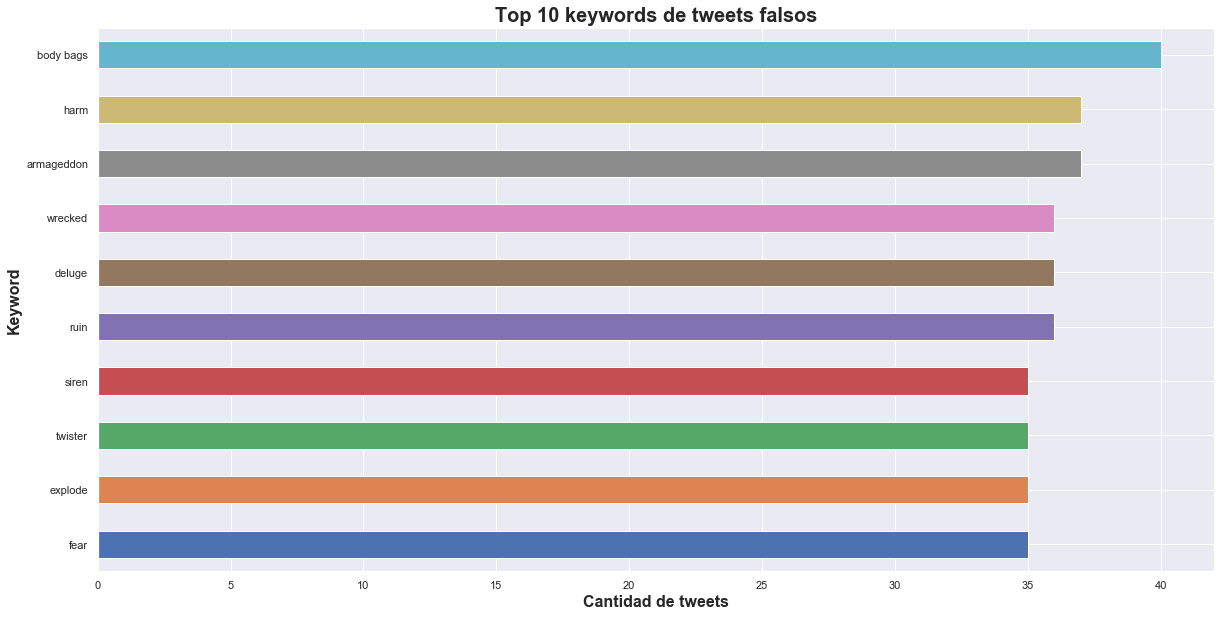

In [19]:
keywords_falsos.value_counts().sort_values(ascending=False).head(10).T\
    .sort_values(ascending=True)\
    .plot(figsize=(20,10),kind='barh',rot=0,color=my_colors);

plt.ylabel('Keyword', fontsize=16, fontweight='bold')
plt.title('Top 10 keywords de tweets falsos',fontsize=20, fontweight='bold')
plt.xlabel('Cantidad de tweets', fontsize=16, fontweight='bold');

## Análisis de menciones

Vamos a analizar la naturaleza de los tweets en base a si se realiza alguna mención en el mismo o no.

In [20]:
train_df['tiene_menciones'] = train_df['text'].str.contains('@')

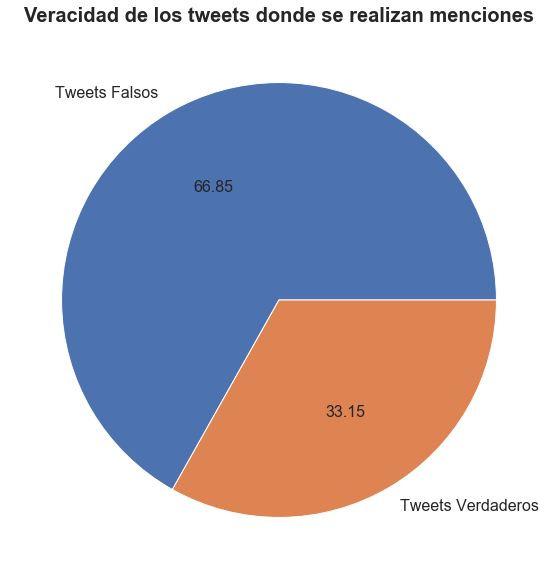

In [21]:
train_df.loc[train_df['tiene_menciones']]['target'].value_counts().plot.pie(labels=['Tweets Falsos',\
                                                        'Tweets Verdaderos'],\
                                                figsize=(10, 10),\
                                                autopct='%.2f', fontsize=16)

plt.ylabel('');
plt.title('Veracidad de los tweets donde se realizan menciones',fontsize=20,weight='bold');

Podemos ver que en 2/3 de los tweets en donde se realiza alguna mención, el tweet resulta ser falso.

## Análisis de hashtags

Vemos si hay alguna relación entre la cantidad de hashtags del tweet y la veracidad del mismo.

In [22]:
train_df['cantidad_de_hashtags'] = train_df['text'].str.count('#')

In [23]:
train_df.groupby(['cantidad_de_hashtags','target']).agg({'id':'count'})

id
cantidad_de_hashtags target      
0                    False   3456
                     True    2396
1                    False    482
                     True     482
2                    False    202
                     True     203
3                    False    108
                     True     100
4                    False     45
                     True      38
5                    False     18
                     True      23
6                    False     19
                     True       7
7                    False      4
                     True       4
8                    False      1
                     True       7
9                    False      2
10                   False      3
                     True       7
11                   False      2
13                   True       4

No aporta nada, esta dividido bastante equitativamente; hay que ver si podemos hacer algo distinto con los hashtags.

## Análisis de "tweets expresivos"

Consideramos como "tweet expresivo" a los tweets en donde se utiliza múltiples signos de exclamación o interrogación consecutivos.

In [24]:
train_df['es_expresivo'] = (train_df['text'].str.contains('\!\!') | train_df['text'].str.contains('\?\?'))

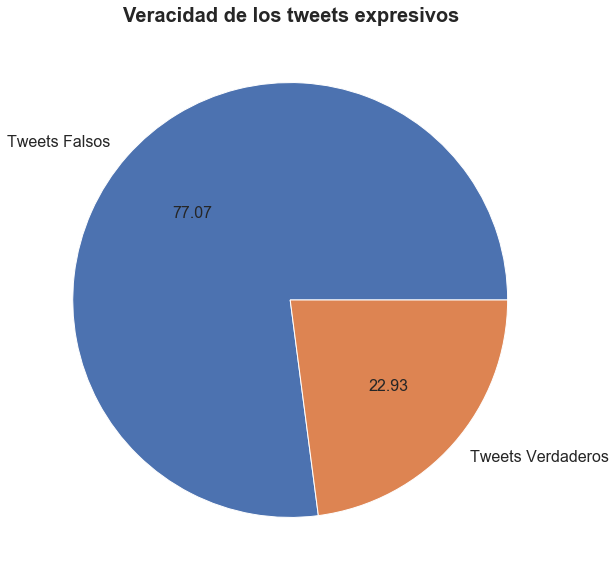

In [25]:
train_df.loc[train_df['es_expresivo']]['target'].value_counts().plot.pie(labels=['Tweets Falsos',\
                                                        'Tweets Verdaderos'],\
                                                figsize=(10, 10),\
                                                autopct='%.2f', fontsize=16)

plt.ylabel('');
plt.title('Veracidad de los tweets expresivos',fontsize=20,weight='bold');

Como podría esperarse, los tweets en donde se utilizan signos de puntuación de manera exagerada, en general para resaltar una emoción del usuario, no suelen ser sobre noticias reales.

## Hay algún registro que el <i><b>text</b></i> NO contenga la <i><b>keyword</b></i>?

In [26]:
def f_aux(row):
  if str(row['keyword']).lower() in str(row['text']).lower():
    return True
  return False

train_df['contiene_key'] = train_df.loc[~train_df['keyword'].isnull()].apply(f_aux,axis=1)

In [27]:
train_df['contiene_key'].value_counts()

True     6700
False     852
Name: contiene_key, dtype: int64

In [28]:
train_df.loc[train_df['contiene_key']==False].head(10)[['keyword','text']]

,keyword,text
32,ablaze,We always try to bring the heavy. #metal #RT h...
40,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...
45,ablaze,I gained 3 followers in the last week. You? Kn...
48,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...
49,ablaze,First night with retainers in. It's quite weir...
52,ablaze,SANTA CRUZ ÂÃÃ Head of the St Elizabeth Pol...
54,ablaze,Noches El-Bestia '@Alexis_Sanchez: happy to se...
83,accident,#TruckCrash Overturns On #FortWorth Interstate...
103,aftershock,'The man who can drive himself further once th...
105,aftershock,'There is no victory at bargain basement price...


In [29]:
train_df.iloc[5540]['text']

'Radioactive Box Quarantined - IsraelÂ\x89Ã\x9bÂªs Ashdod Port was evacuated when emergency teams discovered radiation emittin... http://t.co/swQ5lMyDka'

In [30]:
train_df.iloc[103]['text']

"'The man who can drive himself further once the effort gets painful is the man who will win.' \nRoger Bannister"

In [31]:
train_df.iloc[83]['text']

"#TruckCrash Overturns On #FortWorth Interstate http://t.co/Rs22LJ4qFp Click here if you've been in a crash&gt;http://t.co/Ld0unIYw4k"

In [32]:
print(train_df.iloc[5540]['keyword'])
print(train_df.iloc[5540]['text'])

radiation emergency
Radioactive Box Quarantined - IsraelÂÃÂªs Ashdod Port was evacuated when emergency teams discovered radiation emittin... http://t.co/swQ5lMyDka


In [33]:
train_df.loc[train_df['contiene_key']==False]['target'].value_counts()

False    500
True     352
Name: target, dtype: int64

Podemos observar que de todos los datos que tienen keyword válido, solo <b>6700</b> 
son los que contienen exactamente la palabra. Los otros <b>852</b> son o interpretaciones del tweet y ruido. No se considera que vale la pena quitar 852 registros por la posibilidad de que la mayoria sean o no ruido.

In [34]:
df1 =keywords_verdaderos.value_counts().to_frame().reset_index()
df1.columns = ['keyword','count']

df2 =keywords_falsos.value_counts().to_frame().reset_index()
df2.columns = ['keyword','count']

pd.merge(df1,df2,how='inner',on='keyword')

,keyword,count_x,count_y
0,outbreak,39,1
1,typhoon,37,1
2,oil spill,37,1
3,suicide bombing,32,1
4,suicide bomb,32,3
...,...,...,...
212,epicentre,1,11
213,electrocute,1,31
214,blazing,1,33
215,body bags,1,40


In [0]:
#### me falta cerrar el grafico de este analisis para visualizarlo mejor

## Más analisis de Longitud- Covarianza y Correlacion

In [35]:
train_df['longitud_del_tweet'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
longitud_del_tweet,7613.0,101.336136,33.991338,7.0,78.0,107.0,134.0,163.0


Estaría bueno analizar más en detalle que va sucediendo a medida que la longitud crece, que sucede con el target, es "mas real" o no el tweet?<br>
Creamos unas categorías segun lo visto anteriormente donde de todas las longitudes el 25% promedio esta en 78, el 50% en 107 y asi ... la idea de estas categorías es agrupar rangos entre 0 a 25 , 25 a 50 , 50 a 75 y 75 a 100 segun estas medidas obtenidas.

In [36]:
train_df.loc[train_df['longitud_del_tweet']<78.0,'Categ']="0 a 25"
train_df.loc[train_df['longitud_del_tweet']>=78.0,'Categ']="25 a 50"
train_df.loc[train_df['longitud_del_tweet']>=107.0,'Categ']= "50 a 75"
train_df.loc[train_df['longitud_del_tweet']>=134.0,'Categ']= "75 a 100"

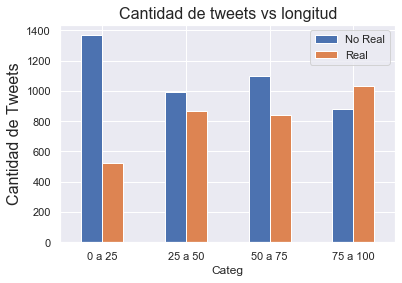

In [37]:
df_aux = train_df.groupby(['Categ','target'])['id'].count().unstack()
df_aux.columns = ['No Real','Real']
df_aux.plot.bar();
plt.xticks(rotation=0)
plt.title('Cantidad de tweets vs longitud', fontsize=16)
plt.ylabel('Cantidad de Tweets', fontsize=16);

Aca podemos ver que a una longitud menor es más probable que sea un tweet no real y que cuanto más largo sea el tweet mayor su probabilidad de ser real.
<br>
La idea ahora es analizar cual es la covarianza y correlacion entre estas categorias creadas en base a su longitud (como largo de la cadena) vs target.

In [38]:
df_aux = train_df
df_aux['Categ_A'] = np.where(df_aux['Categ']=="0 a 25",1,0)
df_aux['Categ_B'] = np.where(df_aux['Categ']=="25 a 50",1,0)
df_aux['Categ_C'] = np.where(df_aux['Categ']=="50 a 75",1,0)
df_aux['Categ_D'] = np.where(df_aux['Categ']=="75 a 100",1,0)

In [39]:
df_aux[['Categ_A','Categ_B','Categ_C','Categ_D','longitud_del_tweet','target']].corr()

,Categ_A,Categ_B,Categ_C,Categ_D,longitud_del_tweet,target
Categ_A,1.000000,-0.327100,-0.337233,-0.333972,-0.820184,-0.176486
Categ_B,-0.327100,1.000000,-0.332614,-0.329397,-0.154991,0.042091
Categ_C,-0.337233,-0.332614,1.000000,-0.339601,0.337340,0.005319
Categ_D,-0.333972,-0.329397,-0.339601,1.000000,0.631737,0.128873
longitud_del_tweet,-0.820184,-0.154991,0.337340,0.631737,1.000000,0.181513
target,-0.176486,0.042091,0.005319,0.128873,0.181513,1.000000


Podemos ver como aumenta la correlacion un poco a medida que la logitud aumenta, pero esto no nos indica si aumenta segun si es o no real